<a target="_blank" href="https://colab.research.google.com/github/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/notebook/Example2_First_order_Markov_Copolymer_Ensemble_onehot_Colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# @title Copyright & License (click to expand)

# MIT License

# Copyright (c) 2023 olsenlabmit

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Download Necessary Files

Downloading local python functions, tables, and dataset
from Github Repo [Polymer-Ensemble-Similarity](https://github.com/olsenlabmit/Polymer-Ensemble-Similarity.git)

In [ ]:
!git clone https://github.com/olsenlabmit/Polymer-Ensemble-Similarity.git
!mv Polymer-Ensemble-Similarity/dataset .
!mv Polymer-Ensemble-Similarity/tables .
!mv Polymer-Ensemble-Similarity/utils .

# Import Required Libraries

In [ ]:
import random
import numpy as np
import shutil
import sys
import os.path
import json
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns


if not shutil.which("rdkit"):
    !pip install -q rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

if not shutil.which("grakel"):
    !pip install grakel

if not shutil.which("dgl"):
    !pip install dgl

if not shutil.which("umap"):
    !pip install umap-learn

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert shutil.which("pyomo")

from pyomo.environ import *

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert shutil.which("cbc") or os.path.isfile("cbc")

from utils.load_networkx import networkx_feat
from utils import macro_unsupervised as unsup
from utils import plot

print("Import Required Libraries Done!")

# Load the First-order Markov Copolymer Ensembles in Example 2.

## First-order Markov Copolymer

<img src="https://drive.google.com/uc?export=view&id=1DnQjZF7Dl70VLSC4LkEwvMwA1POARHC8"  width="50%">

Where blue is R0 and red is R1.


Due to the rules of probability, the sum of the transition probabilities for the addition to ~R0  and ~R1,  are each separately equal to 1. Therefore,

$ t_{00}+t_{01}=1$

$ t_{10}+t_{11}=1$

The first-order Markov process can thus be specified by two independent parameters: (i) the average fraction of R1 in a copolymer chain, $f_{R1}$

$f_{R1} = f_{R1} \cdot t_{11}  +(1-f_{R1} ) \cdot t_{01}$

and (ii) λ which defines the correlations in the linear repeat unit sequence.

$\lambda=t_{00}+ t_{11}  -1$

Here copolymer ensembles are studied with the setting $f_{R0} = f_{R1} = 0.5$, where the average fractions of R0 and R1 are the same in a copolymer chain. Consequently, $t_{00}$, $t_{01}$, $t_{10}$ and $t_{11}$ are solely determined by $\lambda$.

$t_{00}=t_{11}=\frac{1+\lambda}{2}$

$t_{01}=t_{10}=\frac{1-\lambda}{2}$

By modifying the value of $\lambda$, different copolymer ensembles $P(\lambda)$ can be generated. In this example, a series of polymer ensembles are generated for $\lambda$=-1.0 to 1.0 in increments of 0.5. All chains have a fixed length $L=10$.

For the case of $\lambda=-1.0$, the polymer ensemble $P_(\lambda=-1.0)$ has two sequences with equal probability, R0-R1-R0-R1-R0-R1-R0-R1-R0-R1 and  R1-R0-R1-R0-R1-R0-R1-R0-R1-R0.

For the case of $\lambda=1.0$, the polymer ensemble $P_(\lambda=1.0)$ has only two sequences with equal probability R0-R0-R0-R0-R0-R0-R0-R0-R0-R0 and  R1-R1-R1-R1-R1-R1-R1-R1-R1-R1.

Apart from these two special cases, polymer ensembles generated by other $\lambda=1.0$ values [-0.5, 0.0, 0.5] are sampled by following the above first-order Markov process for $3\times10^7$ polymer chains. Check the first-order Markov Copolymer Ensemble generation code [first_order_markov_coplymer_ensemble_generation.py](https://github.com/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/dataset/Example2/first_order_markov_coplymer_ensemble_generation.py) to see how these ensembles are generated.



## Graph Representation Index Sort Function

For example, a first-order copolymer chain is R0-R0-R1-R1-R0-R0-R1-R1-R0-R1.

The label for this coplymer chain is "ID0011001101".

The corresponding graph txt file in the dataset is "ID001100110_graph.txt"

These graph representations are stored in dict where python dictionary. The dictionary does not have order. Therefore, we need to have some sort functions to call them in order according their labels (keys).


In [5]:
# "ID0000000000", "ID1000000000", "ID0100000000", "ID1100000000", ......
# These graph representation labels (keys) are alphabet "ID", and one binary number.
# The alphabet is constant, and the binary number is varying.
# Therefore, we use the binary number for sort function.
# The sort function depends on how the graph labels are created.
def sortFunc(index):
    return index[2:]



**Variables**:

networkx_feat: the function for loading the graph representations of each type polymer chain in one polymer ensemble.

TXT_DATA_PATH: the path for ensemble dataset where each polymer chain graph representation is stored as a txt file.

MON_SMILES: the text file for repeat units

FEAT: Type of fatures for polymer chain repeat units -- one-hot encoding ('onehot') or fingerprints ('fp')

To understand how to generate the txt files for polymer chains, please check the dataset [README.md](https://github.com/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/dataset/README.md).

## Load Graph Representations and Weights in Ensemble $P(\lambda=1.0)$

In [32]:
Ensemble_lambda_P10 = networkx_feat(
    TXT_DATA_PATH="./dataset/Example2/Ensemble_lambda_P10/",
    MON_SMILES="tables/SMILES_repeatunit.txt",
    FEAT="onehot",
)

with open("./dataset/Example2/Ensemble_lambda_P10_weight.json", "r") as json_file:
    Ensemble_lambda_P10_weight = json.load(json_file)

## Visualize Graph Representations in Ensemble $P(\lambda=1.0)$

ID0000000000: 


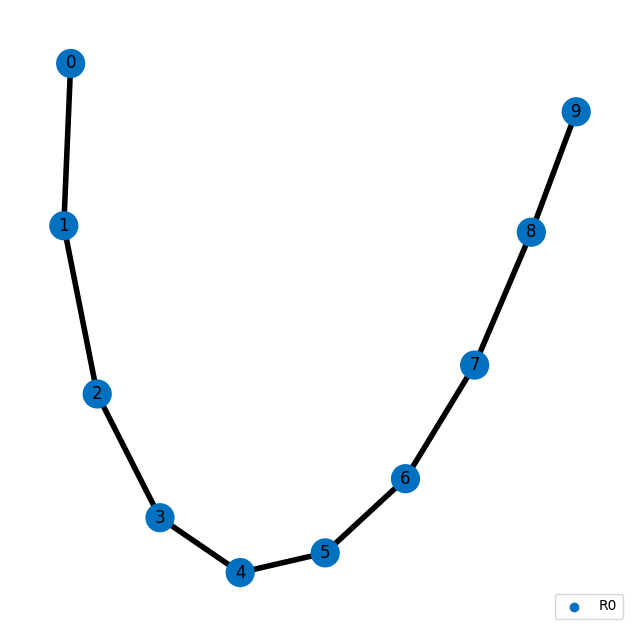

{0: 'R0', 1: 'R0', 2: 'R0', 3: 'R0', 4: 'R0', 5: 'R0', 6: 'R0', 7: 'R0', 8: 'R0', 9: 'R0'}




ID1111111111: 


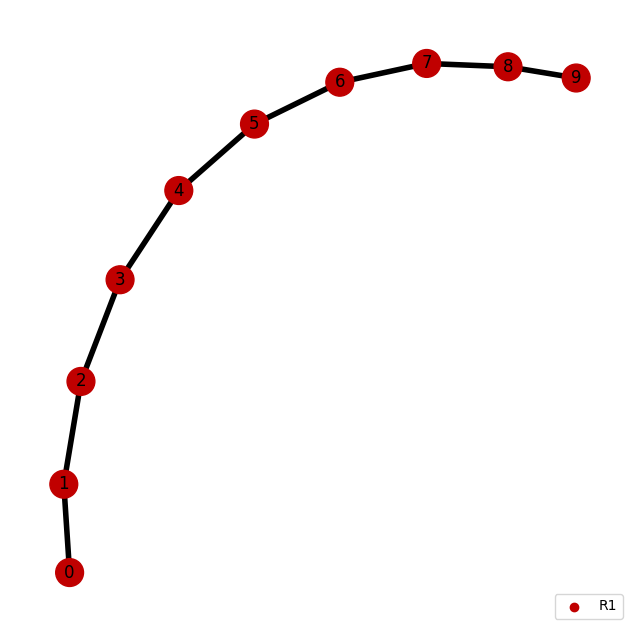

{0: 'R1', 1: 'R1', 2: 'R1', 3: 'R1', 4: 'R1', 5: 'R1', 6: 'R1', 7: 'R1', 8: 'R1', 9: 'R1'}






In [33]:
Ensemble_lambda_P10_indexs = list(Ensemble_lambda_P10.keys())
Ensemble_lambda_P10_indexs.sort(key=sortFunc)

for i in range(0, len(Ensemble_lambda_P10_indexs)):
    print(Ensemble_lambda_P10_indexs[i] + ": ")
    plot.graph(Ensemble_lambda_P10[Ensemble_lambda_P10_indexs[i]])
    print("\n")
    print("\n")

## Load Graph Representations and Weights in Ensemble $P(\lambda=0.5)$

In [34]:
Ensemble_lambda_P05 = networkx_feat(
    TXT_DATA_PATH="./dataset/Example2/Ensemble_lambda_P05/",
    MON_SMILES="tables/SMILES_repeatunit.txt",
    FEAT="onehot",
)

with open("./dataset/Example2/Ensemble_lambda_P05_weight.json", "r") as json_file:
    Ensemble_lambda_P05_weight = json.load(json_file)

## Visualize Graph Representations in Ensemble $P(\lambda=0.5)$

In [35]:
# Ensemble $P(\lambda=0.5)$ has 1024 types of polymer molecules.
# Uncomment the following code if you want to visualize them.

# Ensemble_lambda_P05_indexs = list(Ensemble_lambda_P05.keys())
# Ensemble_lambda_P05_indexs.sort(key=sortFunc)

# for i in range(0,len(Ensemble_lambda_P05_indexs)):
#    print(Ensemble_lambda_P05_indexs[i]+": ")
#    plot.graph(Ensemble_lambda_P05[Ensemble_lambda_P05_indexs[i]])
#    print("\n")
#    print("\n")

## Load Graph Representations and Weights in Ensemble $P(\lambda=0.0)$

In [36]:
Ensemble_lambda_00 = networkx_feat(
    TXT_DATA_PATH="./dataset/Example2/Ensemble_lambda_00/",
    MON_SMILES="tables/SMILES_repeatunit.txt",
    FEAT="onehot",
)

with open("./dataset/Example2/Ensemble_lambda_00_weight.json", "r") as json_file:
    Ensemble_lambda_00_weight = json.load(json_file)

## Visualize Graph Representations in Ensemble $P(\lambda=0.0)$

In [37]:
# Ensemble $P(\lambda=0.0)$ has 1024 types of polymer molecules.
# Uncomment the following code if you want to visualize them.

# Ensemble_lambda_00_indexs = list(Ensemble_lambda_00.keys())
# Ensemble_lambda_00_indexs.sort(key=sortFunc)

# for i in range(0,len(Ensemble_lambda_00_indexs)):
#    print(Ensemble_lambda_00_indexs[i]+": ")
#    plot.graph(Ensemble_lambda_00[Ensemble_lambda_00_indexs[i]])
#    print("\n")
#    print("\n")

## Load Graph Representations and Weights in Ensemble $P(\lambda=-0.5)$

In [38]:
Ensemble_lambda_N05 = networkx_feat(
    TXT_DATA_PATH="./dataset/Example2/Ensemble_lambda_N05/",
    MON_SMILES="tables/SMILES_repeatunit.txt",
    FEAT="onehot",
)

with open("./dataset/Example2/Ensemble_lambda_N05_weight.json", "r") as json_file:
    Ensemble_lambda_N05_weight = json.load(json_file)

## Visualize Graph Representations in Ensemble $P(\lambda=-0.5)$

In [39]:
# Ensemble $P(\lambda=-0.5)$ has 1024 types of polymer molecules.
# Uncomment the following code if you want to visualize them.

# Ensemble_lambda_N05_indexs = list(Ensemble_lambda_N05.keys())
# Ensemble_lambda_N05_indexs.sort(key=sortFunc)

# for i in range(0,len(Ensemble_lambda_N05_indexs)):
#    print(Ensemble_lambda_N05_indexs[i]+": ")
#    plot.graph(Ensemble_lambda_N05[Ensemble_lambda_N05_indexs[i]])
#    print("\n")
#    print("\n")

## Load Graph Representations and Weights in Ensemble $P(\lambda=-1.0)$

In [40]:
Ensemble_lambda_N10 = networkx_feat(
    TXT_DATA_PATH="./dataset/Example2/Ensemble_lambda_N10/",
    MON_SMILES="tables/SMILES_repeatunit.txt",
    FEAT="onehot",
)

with open("./dataset/Example2/Ensemble_lambda_N10_weight.json", "r") as json_file:
    Ensemble_lambda_N10_weight = json.load(json_file)

## Visualize Graph Representations in Ensemble $P(\lambda=-1.0)$

ID0101010101: 


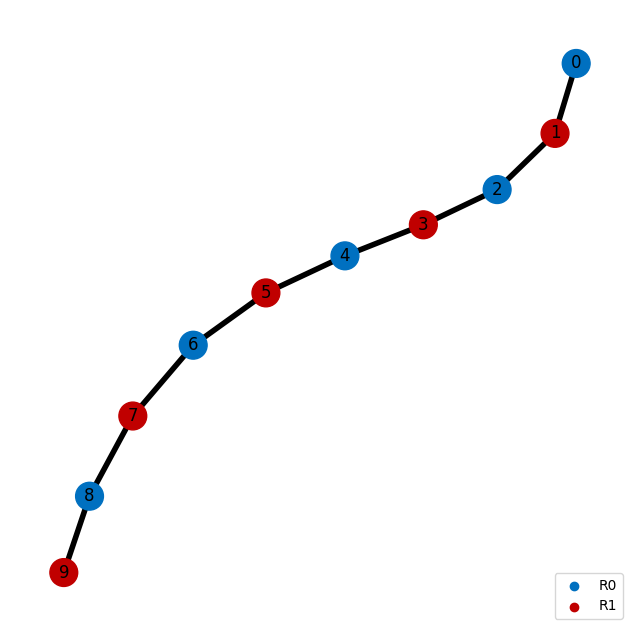

{0: 'R0', 1: 'R1', 2: 'R0', 3: 'R1', 4: 'R0', 5: 'R1', 6: 'R0', 7: 'R1', 8: 'R0', 9: 'R1'}




ID1010101010: 


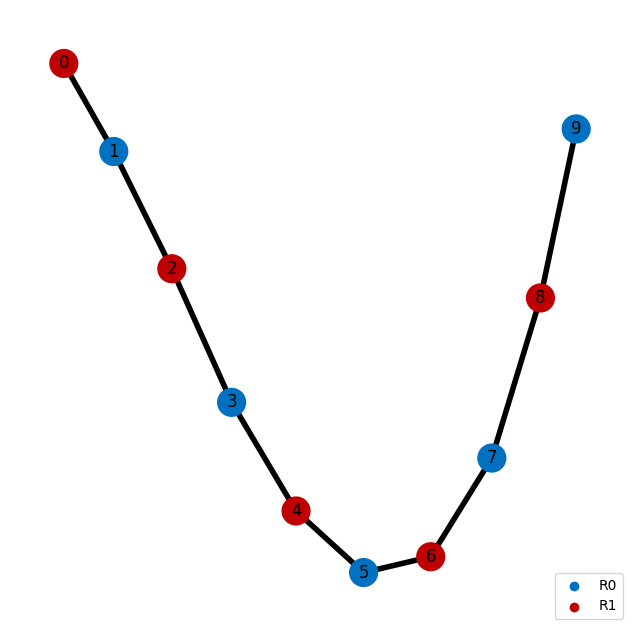

{0: 'R1', 1: 'R0', 2: 'R1', 3: 'R0', 4: 'R1', 5: 'R0', 6: 'R1', 7: 'R0', 8: 'R1', 9: 'R0'}






In [41]:
Ensemble_lambda_N10_indexs = list(Ensemble_lambda_N10.keys())
Ensemble_lambda_N10_indexs.sort(key=sortFunc)

for i in range(0, len(Ensemble_lambda_N10_indexs)):
    print(Ensemble_lambda_N10_indexs[i] + ": ")
    plot.graph(Ensemble_lambda_N10[Ensemble_lambda_N10_indexs[i]])
    print("\n")
    print("\n")

# Polymer Ensembles Similarity Function via Earth Mover's Distance

Use the earth mover's distance (EMD) to compute pairwise similarity scores between polymer ensembles.


$ EMD (P,Q)= \min_{F}\sum_{i=1}^{m}\sum_{j=1}^{n}f_{i,j}d_{i,j}$

$ {\rm subject\ to\ } f_{i,j} \geq 0, {\rm\ for\ any\ } \ 1 \leq i \leq m, 1 \leq j \leq n $

$     \sum_{j=1}^{n}f_{i,j} =w_{pi}, {\rm for\ any} \ 1 \leq i \leq m $

$     \sum_{i=1}^{m}f_{i,j} =w_{qj}, {\rm for\ any} \ 1 \leq j \leq n $

$     \sum_{i=1}^{m}\sum_{j=1}^{n}f_{i,j} = \sum_{i}^{m} w_{pi} = \sum_{j}^{n} w_{qj} = 1 $


One polymer ensemble is defined as $P = \{(p_1,w_{p_1}) ,(p_2,w_{p_2}),...,(p_i,w_{p_i}),...,(p_m,w_{p_m})\}$ has $m$ types of polymer chains, where $p_i$ represents a type of polymer chain and  $w_{p_i}>0$ is its corresponding weight, which can be the mole fraction of this polymer chain in the polymer ensemble. Similarly, the second ensemble $Q = {(q_1,w_{q_1}),(q_2,w_{q_2}),...,(q_j,w_{q_j}),...,(q_n,w_{q_n})}$ has $n$ types of polymer chains. The sums of the weights for $P$ and $Q$ are both normalized and equal to one.

The EMD linear optimization code  refers to [Transportation Networks, ND Pyomo Notebook](https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/03.01-Transportation-Networks.html)

Once $EMD (P,Q)$ is calculated, the similarity score between $P$ and $Q$ is

$S(P,Q) = 1- EMD (P,Q)$


The distance ($d_{i,j}$) between one polymer molecule $p_i$ and another polymer molecule $q_j$ is calculated through graph edit distance. This part of the code builds on [GLAMOUR](https://github.com/learningmatter-mit/GLAMOUR) and networkx function [graph_edit_distance](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.similarity.graph_edit_distance.html).

$d(g_1, g_2) = 1- \exp(-\frac{\alpha \cdot GED(g_1, g_2)}{(N_1 + N_2)/2})$

where $g_i$ is the graph representation of one polymer molecule, $N_i$ is the number of nodes in graph $g_i$, $\alpha$ is a tunable parameter with the default value being 1. [Reference1](https://arxiv.org/abs/1808.05689), [Reference2](https://doi.org/10.1021/acs.macromol.3c00761)

In [42]:
def Similarity_Score_EMD_Calculation(
    ensembleP=None,
    ensembleP_weight=None,
    ensembleQ=None,
    ensembleQ_weight=None,
    alpha=1,
    print_details=False,
):
    # Data loading w_i, w_j, d_ij

    ## load the weight w_i of Ensemble P
    Demand = {}

    ensembleP_number = len(ensembleP_weight)

    ensembleP_weight_sum = sum(ensembleP_weight.values())

    ensembleP_indexs = list(ensembleP.keys())
    ensembleP_indexs.sort(key=sortFunc)

    for i in range(0, ensembleP_number):
        Demand["p" + str(i + 1)] = (
            ensembleP_weight[ensembleP_indexs[i]] / ensembleP_weight_sum
        )

    ## load the weight w_j of Ensemble Q
    Supply = {}

    ensembleQ_number = len(ensembleQ_weight)

    ensembleQ_weight_sum = sum(ensembleQ_weight.values())

    ensembleQ_indexs = list(ensembleQ.keys())
    ensembleQ_indexs.sort(key=sortFunc)

    for j in range(0, ensembleQ_number):
        Supply["q" + str(j + 1)] = (
            ensembleQ_weight[ensembleQ_indexs[j]] / ensembleQ_weight_sum
        )

    ## load the distance matrix D = [d_ij]
    D = {}
    for i in range(0, ensembleP_number):
        for j in range(0, ensembleQ_number):
            ### calculate the GED between two graph representations
            GED = unsup.edit_distance(
                ensembleP[ensembleP_indexs[i]],
                ensembleQ[ensembleQ_indexs[j]],
                node_attr="h",
                indel_mul=1,
                sub_mul=1,
            )

            ### calculate the number of nodes in graph N_i
            N_i = ensembleP[ensembleP_indexs[i]].number_of_nodes()

            ### calculate the number of nodes in graph N_j
            N_j = ensembleQ[ensembleQ_indexs[j]].number_of_nodes()

            D[("p" + str(i + 1), "q" + str(j + 1))] = 1 - np.exp(
                -alpha * GED / (0.5 * (N_i + N_j))
            )

    # The following are optimization steps
    ## Step 0: Create an instance of the model
    model = ConcreteModel()
    model.dual = Suffix(direction=Suffix.IMPORT)

    ## Step 1: Define index sets
    CUS = list(Demand.keys())
    SRC = list(Supply.keys())

    ## Step 2: Define the decision
    model.x = Var(CUS, SRC, domain=NonNegativeReals)

    ## Step 3: Define Objective
    model.Cost = Objective(
        expr=sum([D[c, s] * model.x[c, s] for c in CUS for s in SRC]), sense=minimize
    )

    ## Step 4: Constraints
    model.src = ConstraintList()
    for s in SRC:
        model.src.add(sum([model.x[c, s] for c in CUS]) <= Supply[s])

    model.dmd = ConstraintList()
    for c in CUS:
        model.dmd.add(sum([model.x[c, s] for s in SRC]) == Demand[c])

    ## Step 5: call the cbc solver to solve this EMD problem
    results = SolverFactory("cbc").solve(model)

    ## Step 6: return EMD result
    if "ok" == str(results.Solver.status):
        if print_details == True:
            for s in SRC:
                for c in CUS:
                    if model.x[c, s]() > 0:
                        print(
                            "Ship from ",
                            s,
                            " to ",
                            c,
                            ":",
                            model.x[c, s](),
                            "*",
                            D[c, s],
                        )
        return 1 - model.Cost()

    else:
        print("No Valid Solution Found")
        return False

# Calculation of $S(P(\lambda=1.0),P(\lambda=-1.0))$

In [48]:
Similarity_Score = Similarity_Score_EMD_Calculation(
    ensembleP=Ensemble_lambda_P10,
    ensembleP_weight=Ensemble_lambda_P10_weight,
    ensembleQ=Ensemble_lambda_N10,
    ensembleQ_weight=Ensemble_lambda_N10_weight,
    alpha=1,
    print_details=False,
)

In [49]:
print("Similarity Score between P(λ=1.0) and P(λ=-1.0) = %.2f" % Similarity_Score)

Similarity Score between P(λ=1.0) and P(λ=-1.0) = 0.61


# Calculation of All the Pairwise $S(P(\lambda_1),P(\lambda_2))$

This step will take a long time.

In [58]:
# Users can uncomment the following to calculate all the pairwise
# similarity scores between polymer ensembles.
# This step will take a long time.


# Example2_Ensembles = [
#    Ensemble_lambda_P10,
#    Ensemble_lambda_P05,
#    Ensemble_lambda_00,
#    Ensemble_lambda_N05,
#    Ensemble_lambda_N10]

# Example2_Ensembles_weights = [
#    Ensemble_lambda_P10_weight,
#    Ensemble_lambda_P05_weight,
#    Ensemble_lambda_00_weight,
#    Ensemble_lambda_N05_weight,
#    Ensemble_lambda_N10_weight]

# Example2_Ensembles_names = [
#    "P(λ=1.0)",
#    "P(λ=0.5)",
#    "P(λ=0.0)",
#    "P(λ=0.5)",
#    "P(λ=-1.0)"]

# S_Matrix = np.ones([5,5])

# for i in range(0,4):

#    for j in range(i+1,5):
#
#        S_ij = Similarity_Score_EMD_Calculation(
#                        ensembleP=Example2_Ensembles[i],
#                        ensembleP_weight=Example2_Ensembles_weights[i],
#                        ensembleQ=Example2_Ensembles[j],
#                        ensembleQ_weight=Example2_Ensembles_weights[j],
#                        alpha=1,
#                        print_details=False,
#                      )
#
#        print(f"S({Example2_Ensembles_names[i]},{Example2_Ensembles_names[j]})=",
#              S_ij)
#        print('\n')
#
#        S_Matrix[i,j] = S_ij

#        S_Matrix[j,i] = S_ij

## Load the  Storage Results of $S(P(\lambda_1),P(\lambda_2))$

$S(P(\lambda_1),P(\lambda_2))$ have been calculated and the results were stored.

Users can directly load the $S(P(\lambda_1),P(\lambda_2))$ if users want to see the results but do not have time to run the previous step.

In [53]:
S_Matrix = np.load("./dataset/Example2/cp_onehot_55.npy")

# Visualize $S(P(\lambda_1),P(\lambda_2))$

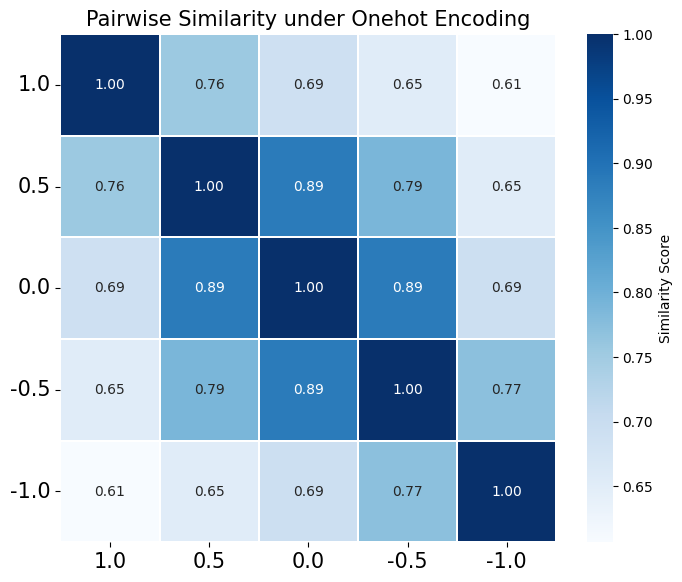

In [62]:
fig, ax = plt.subplots(figsize=(8, 6.6), sharey=True)

x_labels = ["1.0", "0.5", "0.0", "-0.5", "-1.0"]
y_labels = ["1.0", "0.5", "0.0", "-0.5", "-1.0"]

sns.heatmap(
    S_Matrix,
    linewidth=0.3,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={"label": "Similarity Score"},
)
ax.set_title(r"Pairwise Similarity under Onehot Encoding", fontsize=15)
ax.set_xticklabels(x_labels, rotation=0, fontsize=15, horizontalalignment="center")
ax.set_yticklabels(y_labels, rotation=360, fontsize=15, horizontalalignment="right")
plt.show()